In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

In [2]:
RATIOS = ['L1',
       'L2', 'L3', 'NCL_CF', 'CASH_TA', 'INV_COGS', 'CC_SAL', 'TL_COST',
       'CL_COST', 'SAL_TA', 'EQ_TA', 'EQ_TL', 'CL_CC', 'LTC_NCA', 'TZ',
       'CF_TL', 'CL_TA', 'NCL_TA', 'EBT_REV', 'ROS', 'EAT_REV', 'ROA', 'ROE',
       'CF_TA', 'CF_SAL', 'LABOR_EAT', 'LABOR_REV']

PRIMARY_VALUES = [
    'CA', 'CASH',
       'CL', 'EQ', 'NCL', 'TA', 'TL', 'CC', 'INV', 'CF_NETTO', 'CF_SELFFIN',
       'REV', 'VA', 'OE', 'EAT', 'EBIT', 'SAL', 'COST', 'INT'
]


REDUCED_FEATURE_SET = ['L1', 'L3', 'EQ_TA', 'CL_CC', 'LTC_NCA', 'TZ', 'CF_TL', 'CL_TA', 'ROS', 'ROA', 'ROE']

SKNACE_ONE_HOT = ['sknace_C', 'sknace_F', 'sknace_G', 'sknace_H', 'sknace_M', 'sknace_other']

In [4]:
training_raw = pd.read_csv('../../../DATA/FINAL/final/training_sample.csv')
testing_raw = pd.read_csv('../../../DATA/FINAL/final/testing_sample.csv')
training_raw.shape, testing_raw.shape

((7188, 107), (1797, 107))

In [5]:
SAL_CLASSES = training_raw['sal_class'].unique()
SKNACE_GROUPS = training_raw['sknace_division_normalized'].unique()

In [6]:
training_filled = training_raw.copy()
testing_filled = testing_raw.copy()

In [18]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

FINAL_FEATURE_SET = ['L3', 'EQ_TA', 'LTC_NCA', 'TZ', 'CF_TL', 'CL_TA', 'ROS', 'ROA', 'ROE']


In [19]:

Q = training_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

control_group_ratio = 1.5

training_balanced = (
    pd.concat(
        [
            training_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q * control_group_ratio)),
            training_filled.query('combined_issue_criteria_3y_off == 1').sample(Q),
        ], axis = 0
    )
)



Q_test = testing_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

testing_balanced = (
    pd.concat(
        [
            testing_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q_test * control_group_ratio)),
            testing_filled.query('combined_issue_criteria_3y_off == 1').sample(Q_test),
        ], axis = 0
    )
)


X_train_balanced = training_balanced[FINAL_FEATURE_SET].values
y_train_balanced = training_balanced['combined_issue_criteria_3y_off'].values

X_test_balanced = testing_balanced[FINAL_FEATURE_SET].values
y_test_balanced = testing_balanced['combined_issue_criteria_3y_off'].values

X_train_imbalanced = training_filled[FINAL_FEATURE_SET].values
y_train_imbalanced = training_filled['combined_issue_criteria_3y_off'].values

X_test_imbalanced = testing_filled[FINAL_FEATURE_SET].values
y_test_imbalanced = testing_filled['combined_issue_criteria_3y_off'].values



# X_train_valid_balanced, X_valid_valid_balanced, y_train_valid_balanced, y_valid_valid_balanced = train_test_split(
#     X_train_balanced, y_train_balanced, test_size=0.2, random_state=42)


X_train_valid_imbalanced, X_valid_valid_imbalanced, y_train_valid_imbalanced, y_valid_valid_imbalanced = train_test_split(
    X_train_imbalanced, y_train_imbalanced, test_size=0.2, random_state=42)


from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

# Assuming X_train_valid_imbalanced and y_train_valid_imbalanced are already defined
# Count the number of samples in each class
counter = Counter(y_train_valid_imbalanced)
print(f"Original class distribution: {counter}")

# Calculate the number of samples needed for the majority class (class 0) to achieve a 3:2 ratio
minority_class_count = counter[1]
desired_majority_class_count = (minority_class_count * 3) // 2

# Define the sampling strategy for RandomUnderSampler
sampling_strategy = {0: desired_majority_class_count, 1: minority_class_count}

# Apply RandomUnderSampler with the defined sampling strategy
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_valid_balanced, y_train_valid_balanced = rus.fit_resample(X_train_valid_imbalanced, y_train_valid_imbalanced)



Original class distribution: Counter({0.0: 5183, 1.0: 567})


In [20]:

from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, fbeta_score, f1_score
from imblearn.metrics import specificity_score


# Create a custom scorer for use in GridSearchCV or RFECV
f2_scorer = make_scorer(fbeta_score, beta=2)
f3_scorer = make_scorer(fbeta_score, beta=3)


# Define a custom scoring function
def custom_score(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    # Weight recall more heavily
    return 0.8 * recall + 0.2 * accuracy

custom_scorer = make_scorer(custom_score, greater_is_better=True)


def eval(real, pred, label):
    print(f'real_positives = {sum(real)}, total = {len(real)}')
    recall = recall_score(real, pred)
    accuracy = accuracy_score(real, pred)
    print(f"{label} Accuracy:", accuracy)
    print(f"{label} Precision:", precision_score(real, pred))
    print(f"{label} Recall:", recall)
    print(f"{label} Specificity:", specificity_score(real, pred))
    # print(f"{label} Balanced Accuracy:", balanced_accuracy_score(real, pred))
    print(f"{label} F1 Score:", f1_score(real, pred))
    # print(f"{label} F2 Score:", fbeta_score(real, pred, beta=2))
    # print(f"{label} Custom Scorer:", custom_score(real, pred))

    cm = confusion_matrix(real, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(label)
    plt.show()



def predict_w_threshold(estimator, X, threshold):
    proba = estimator.predict_proba(X)[:, 1]
    return (proba >= threshold).astype(int)

In [21]:

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

## FINAL TESTING

### RF

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7627906976744186
FINAL MODEL BALANCED Precision: 0.7430555555555556
FINAL MODEL BALANCED Recall: 0.622093023255814
FINAL MODEL BALANCED Specificity: 0.8565891472868217
FINAL MODEL BALANCED F1 Score: 0.6772151898734178


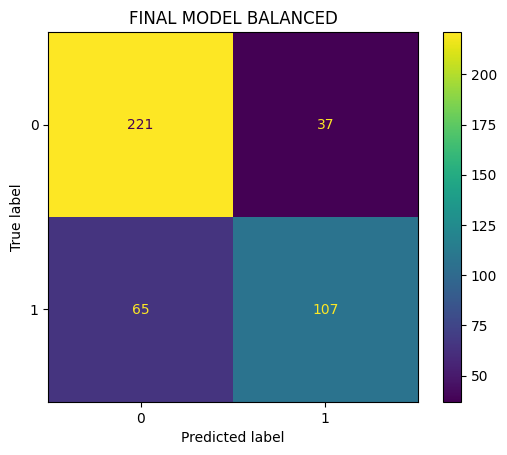

real_positives = 172.0, total = 1797
FINAL MODEL IMBALANCED Accuracy: 0.8024485253199778
FINAL MODEL IMBALANCED Precision: 0.2695214105793451
FINAL MODEL IMBALANCED Recall: 0.622093023255814
FINAL MODEL IMBALANCED Specificity: 0.8215384615384616
FINAL MODEL IMBALANCED F1 Score: 0.3760984182776801


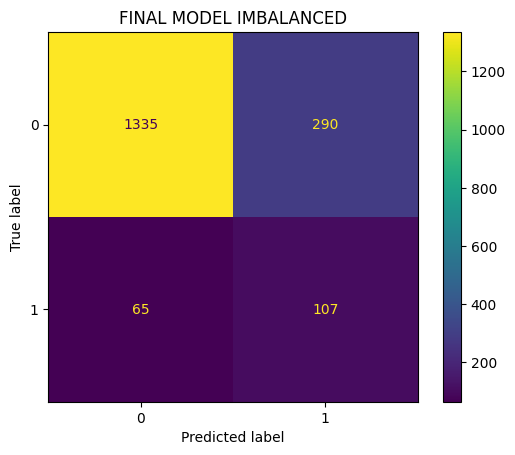

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7325581395348837
FINAL MODEL BALANCED Precision: 0.6492146596858639
FINAL MODEL BALANCED Recall: 0.7209302325581395
FINAL MODEL BALANCED Specificity: 0.7403100775193798
FINAL MODEL BALANCED F1 Score: 0.6831955922865014


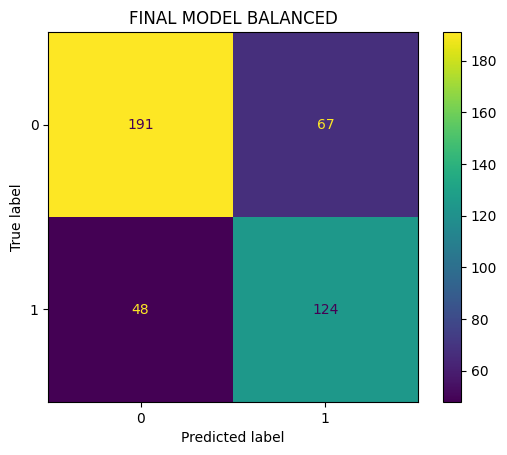

real_positives = 172.0, total = 1797
FINAL MODEL IMBALANCED Accuracy: 0.7334446299387869
FINAL MODEL IMBALANCED Precision: 0.22342342342342342
FINAL MODEL IMBALANCED Recall: 0.7209302325581395
FINAL MODEL IMBALANCED Specificity: 0.7347692307692307
FINAL MODEL IMBALANCED F1 Score: 0.34112792297111416


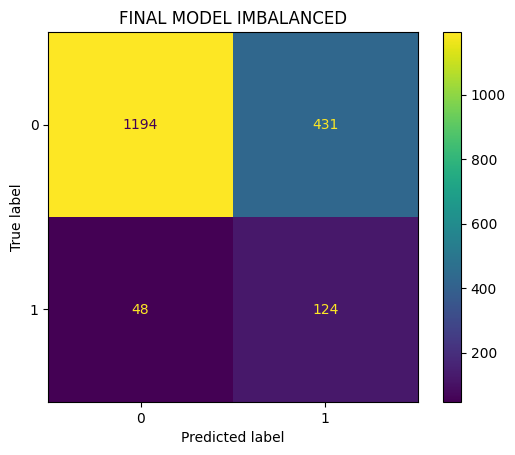

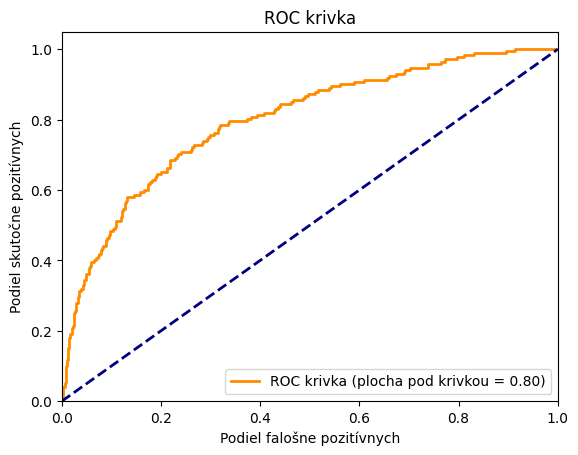

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf_final = (RandomForestClassifier(
    random_state=42,
    max_depth=  30,
    max_features= 'log2',
    min_samples_leaf= 2,
    min_samples_split= 50,
    n_estimators= 50))


rf_final.fit(X_train_balanced, y_train_balanced)


eval(y_test_balanced, rf_final.predict(X_test_balanced), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, rf_final.predict(X_test_imbalanced), 'FINAL MODEL IMBALANCED')
eval(y_test_balanced,predict_w_threshold(rf_final, X_test_balanced, 0.4), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, predict_w_threshold(rf_final, X_test_imbalanced, 0.4), 'FINAL MODEL IMBALANCED')



y_probs = rf_final.predict_proba(X_test_imbalanced)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_imbalanced, y_probs)

# Compute the AUC score
roc_auc = roc_auc_score(y_test_imbalanced, y_probs)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivka (plocha pod krivkou = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Podiel falošne pozitívnych')
plt.ylabel('Podiel skutočne pozitívnych')
plt.title('ROC krivka')
plt.legend(loc='lower right')
plt.show()

# Compute precision-recall curve
# precision, recall, thresholds = precision_recall_curve(y_test_imbalanced, y_probs)

# # Compute average precision score
# average_precision = average_precision_score(y_test_imbalanced, y_probs)

# # Plot the precision-recall curve
# plt.figure()
# plt.plot(recall, precision, color='blue', lw=2, label=f'PR krivka (Priem. PER = {average_precision:.2f})')
# plt.xlabel('Senzitivita')
# plt.ylabel('Presnosť')
# plt.title('Vzťah presnosti a senzitiviy (Precision-Recall Curve)')
# plt.legend(loc='lower left')
# plt.show()



### XGBoost

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7441860465116279
FINAL MODEL BALANCED Precision: 0.7094594594594594
FINAL MODEL BALANCED Recall: 0.6104651162790697
FINAL MODEL BALANCED Specificity: 0.8333333333333334
FINAL MODEL BALANCED F1 Score: 0.65625


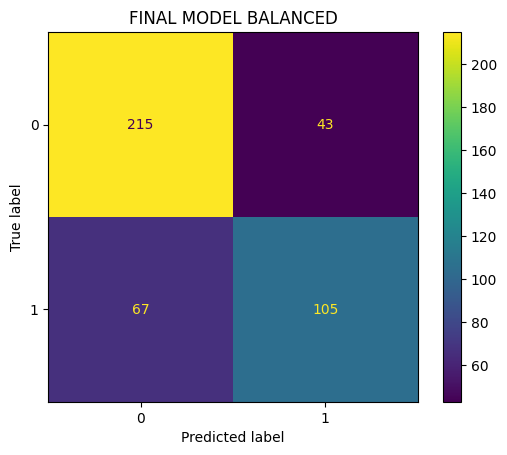

real_positives = 172.0, total = 1797
FINAL MODEL IMBALANCED Accuracy: 0.8091263216471898
FINAL MODEL IMBALANCED Precision: 0.2755905511811024
FINAL MODEL IMBALANCED Recall: 0.6104651162790697
FINAL MODEL IMBALANCED Specificity: 0.8301538461538461
FINAL MODEL IMBALANCED F1 Score: 0.379746835443038


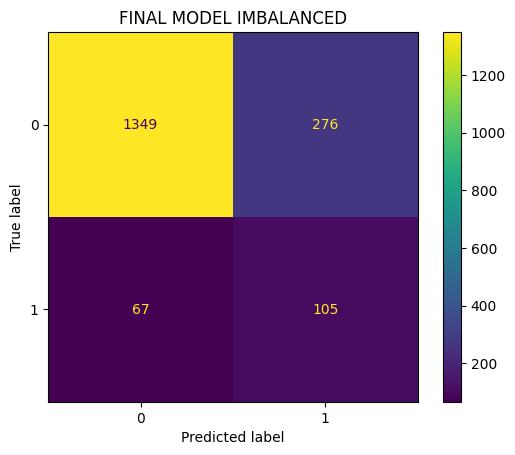

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7441860465116279
FINAL MODEL BALANCED Precision: 0.6684782608695652
FINAL MODEL BALANCED Recall: 0.7151162790697675
FINAL MODEL BALANCED Specificity: 0.7635658914728682
FINAL MODEL BALANCED F1 Score: 0.6910112359550561


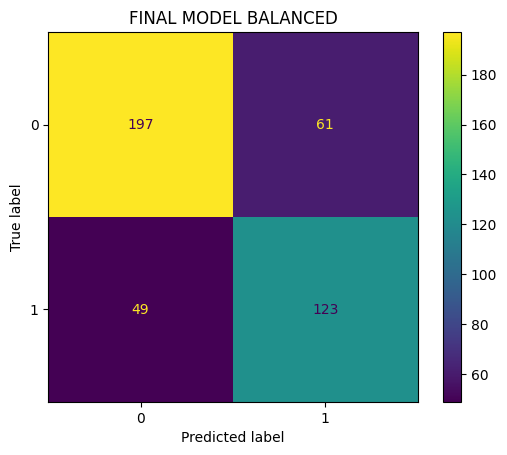

real_positives = 172.0, total = 1797
FINAL MODEL IMBALANCED Accuracy: 0.7434613244296049
FINAL MODEL IMBALANCED Precision: 0.22990654205607478
FINAL MODEL IMBALANCED Recall: 0.7151162790697675
FINAL MODEL IMBALANCED Specificity: 0.7464615384615385
FINAL MODEL IMBALANCED F1 Score: 0.347949080622348


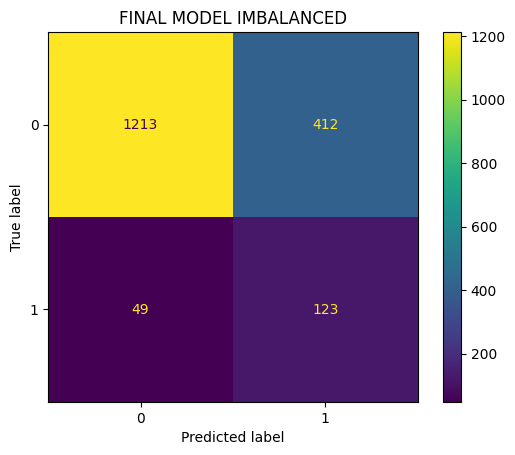

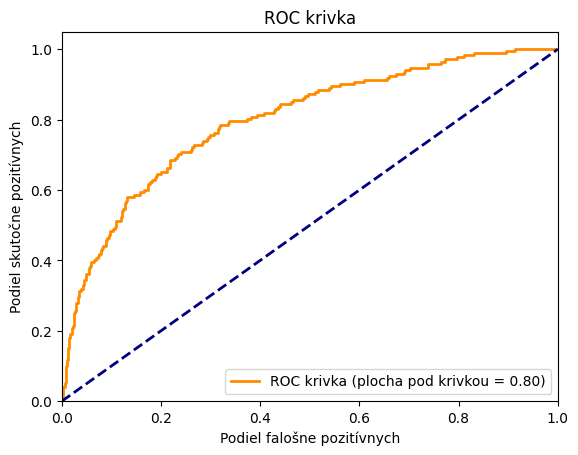

In [37]:
import xgboost as xgb


xgb_final = xgb.XGBClassifier(
    random_state = 37,
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    colsample_bytree=  0.7,
    learning_rate= 0.05,
    max_depth= 5,
    min_child_weight= 3,
    n_estimators= 80,
    subsample= 0.7
)


xgb_final.fit(X_train_balanced, y_train_balanced)


eval(y_test_balanced, xgb_final.predict(X_test_balanced), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, xgb_final.predict(X_test_imbalanced), 'FINAL MODEL IMBALANCED')


eval(y_test_balanced,predict_w_threshold(xgb_final, X_test_balanced, 0.4), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, predict_w_threshold(xgb_final, X_test_imbalanced, 0.4), 'FINAL MODEL IMBALANCED')



y_probs = rf_final.predict_proba(X_test_imbalanced)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_imbalanced, y_probs)

# Compute the AUC score
roc_auc = roc_auc_score(y_test_imbalanced, y_probs)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivka (plocha pod krivkou = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Podiel falošne pozitívnych')
plt.ylabel('Podiel skutočne pozitívnych')
plt.title('ROC krivka')
plt.legend(loc='lower right')
plt.show()

# Compute precision-recall curve
# precision, recall, thresholds = precision_recall_curve(y_test_imbalanced, y_probs)

# # Compute average precision score
# average_precision = average_precision_score(y_test_imbalanced, y_probs)

# # Plot the precision-recall curve
# plt.figure()
# plt.plot(recall, precision, color='blue', lw=2, label=f'PR krivka (Priem. PER = {average_precision:.2f})')
# plt.xlabel('Senzitivita')
# plt.ylabel('Presnosť')
# plt.title('Vzťah presnosti a senzitiviy (Precision-Recall Curve)')
# plt.legend(loc='lower left')
# plt.show()



### SVM

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7418604651162791
FINAL MODEL BALANCED Precision: 0.7163120567375887
FINAL MODEL BALANCED Recall: 0.5872093023255814
FINAL MODEL BALANCED Specificity: 0.8449612403100775
FINAL MODEL BALANCED F1 Score: 0.645367412140575


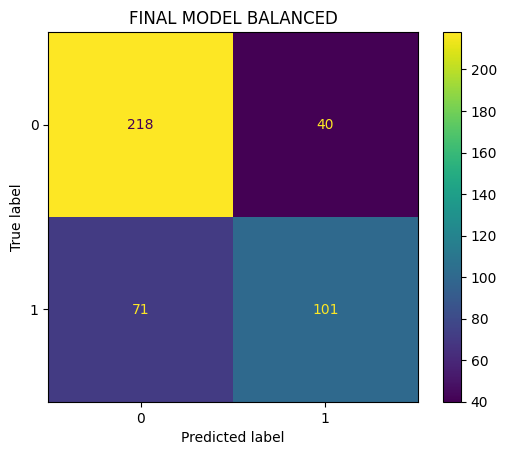

real_positives = 172.0, total = 1797
FINAL MODEL IMBALANCED Accuracy: 0.7996661101836394
FINAL MODEL IMBALANCED Precision: 0.258974358974359
FINAL MODEL IMBALANCED Recall: 0.5872093023255814
FINAL MODEL IMBALANCED Specificity: 0.8221538461538461
FINAL MODEL IMBALANCED F1 Score: 0.3594306049822064


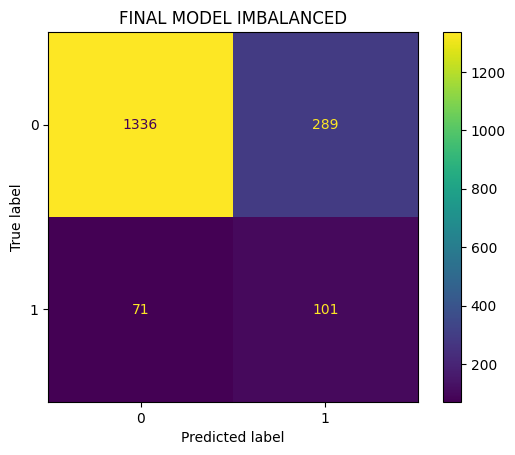

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7023255813953488
FINAL MODEL BALANCED Precision: 0.6122448979591837
FINAL MODEL BALANCED Recall: 0.6976744186046512
FINAL MODEL BALANCED Specificity: 0.7054263565891473
FINAL MODEL BALANCED F1 Score: 0.6521739130434783


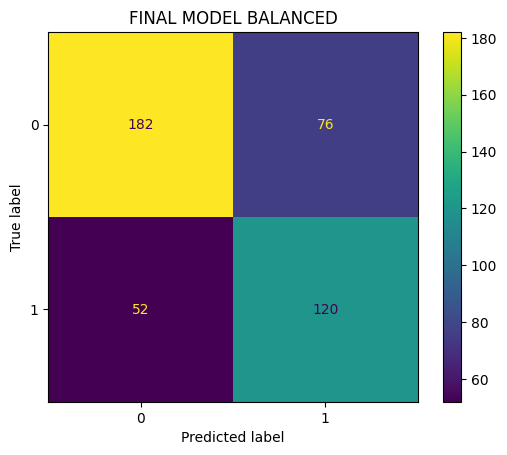

real_positives = 172.0, total = 1797
FINAL MODEL IMBALANCED Accuracy: 0.7089593767390094
FINAL MODEL IMBALANCED Precision: 0.20304568527918782
FINAL MODEL IMBALANCED Recall: 0.6976744186046512
FINAL MODEL IMBALANCED Specificity: 0.7101538461538461
FINAL MODEL IMBALANCED F1 Score: 0.3145478374836173


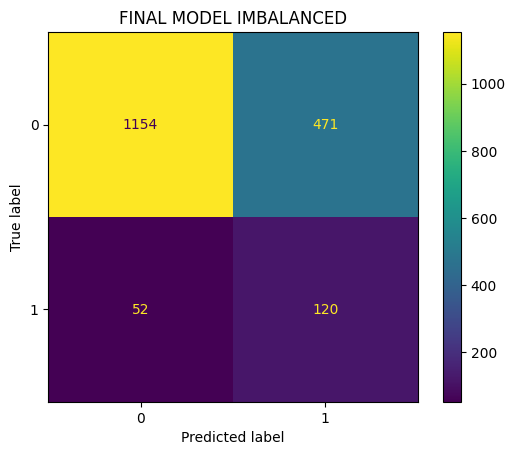

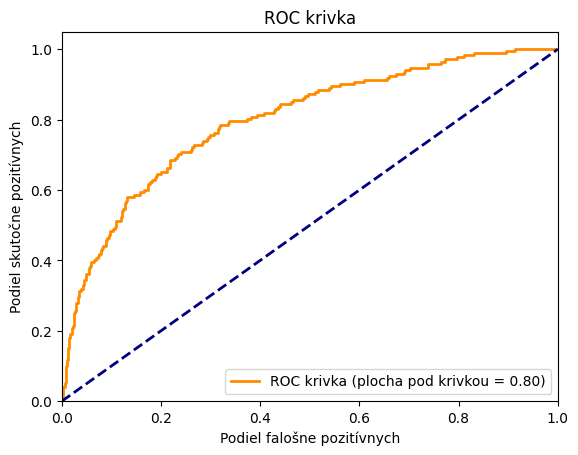

In [39]:

from sklearn.svm import SVC

svm_final = SVC(kernel='rbf', random_state=13, C = 10000, gamma=0.0001, probability=True)

svm_final.fit(X_train_balanced, y_train_balanced)

eval(y_test_balanced, svm_final.predict(X_test_balanced), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, svm_final.predict(X_test_imbalanced), 'FINAL MODEL IMBALANCED')

eval(y_test_balanced,predict_w_threshold(svm_final, X_test_balanced, 0.4), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, predict_w_threshold(svm_final, X_test_imbalanced, 0.4), 'FINAL MODEL IMBALANCED')



y_probs = rf_final.predict_proba(X_test_imbalanced)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_imbalanced, y_probs)

# Compute the AUC score
roc_auc = roc_auc_score(y_test_imbalanced, y_probs)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivka (plocha pod krivkou = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Podiel falošne pozitívnych')
plt.ylabel('Podiel skutočne pozitívnych')
plt.title('ROC krivka')
plt.legend(loc='lower right')
plt.show()

# # Compute precision-recall curve
# precision, recall, thresholds = precision_recall_curve(y_test_imbalanced, y_probs)

# # Compute average precision score
# average_precision = average_precision_score(y_test_imbalanced, y_probs)

# # Plot the precision-recall curve
# plt.figure()
# plt.plot(recall, precision, color='blue', lw=2, label=f'PR krivka (Priem. PER = {average_precision:.2f})')
# plt.xlabel('Senzitivita')
# plt.ylabel('Presnosť')
# plt.title('Vzťah presnosti a senzitiviy (Precision-Recall Curve)')
# plt.legend(loc='lower left')
# plt.show()



### MLP

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7604651162790698
FINAL MODEL BALANCED Precision: 0.7284768211920529
FINAL MODEL BALANCED Recall: 0.6395348837209303
FINAL MODEL BALANCED Specificity: 0.8410852713178295
FINAL MODEL BALANCED F1 Score: 0.6811145510835913


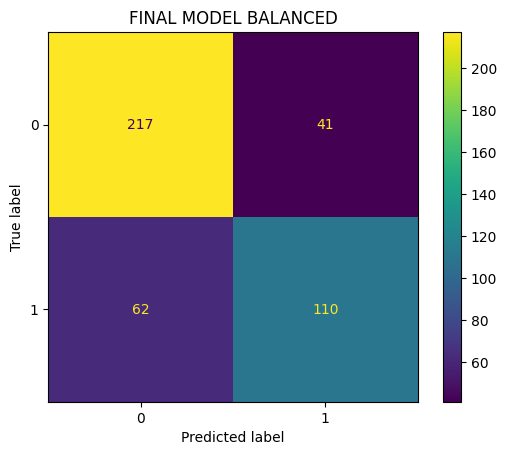

real_positives = 172.0, total = 1797
FINAL MODEL IMBALANCED Accuracy: 0.7941012799109627
FINAL MODEL IMBALANCED Precision: 0.2631578947368421
FINAL MODEL IMBALANCED Recall: 0.6395348837209303
FINAL MODEL IMBALANCED Specificity: 0.8104615384615385
FINAL MODEL IMBALANCED F1 Score: 0.3728813559322034


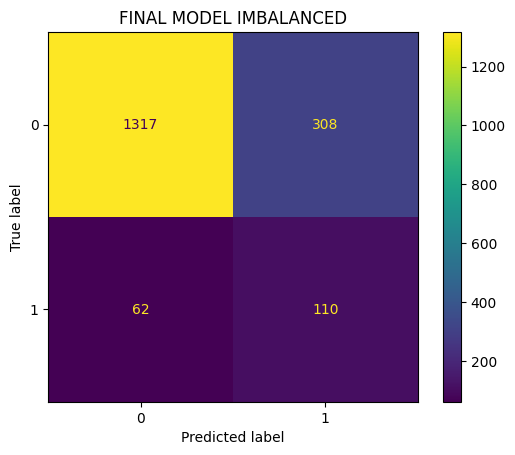

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7325581395348837
FINAL MODEL BALANCED Precision: 0.6507936507936508
FINAL MODEL BALANCED Recall: 0.7151162790697675
FINAL MODEL BALANCED Specificity: 0.7441860465116279
FINAL MODEL BALANCED F1 Score: 0.6814404432132964


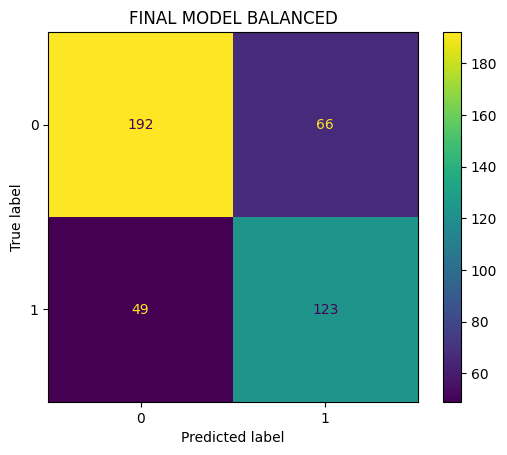

real_positives = 172.0, total = 1797
FINAL MODEL IMBALANCED Accuracy: 0.7239844184752365
FINAL MODEL IMBALANCED Precision: 0.21578947368421053
FINAL MODEL IMBALANCED Recall: 0.7151162790697675
FINAL MODEL IMBALANCED Specificity: 0.7249230769230769
FINAL MODEL IMBALANCED F1 Score: 0.33153638814016173


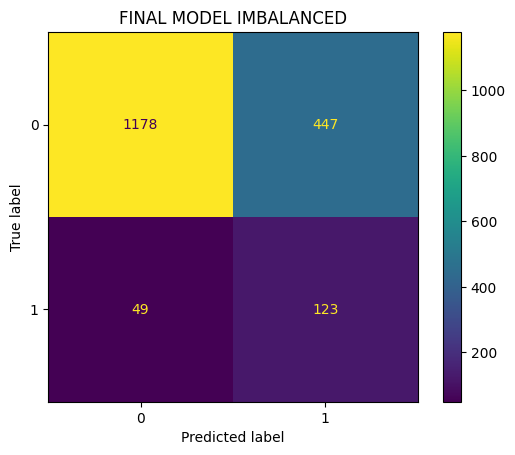

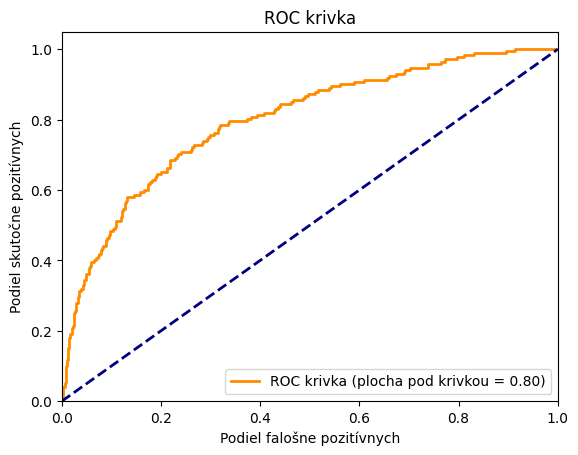

In [40]:
from sklearn.neural_network import MLPClassifier



mlp_final = MLPClassifier(
    random_state=37,
    activation= 'tanh',
    alpha = 1e-05,
    hidden_layer_sizes = (5, 3),
    learning_rate = 'constant',
    max_iter = 500,
    solver = 'adam'
    )

mlp_final.fit(X_train_balanced, y_train_balanced)


eval(y_test_balanced, mlp_final.predict(X_test_balanced), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, mlp_final.predict(X_test_imbalanced), 'FINAL MODEL IMBALANCED')


eval(y_test_balanced,predict_w_threshold(mlp_final, X_test_balanced, 0.4), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, predict_w_threshold(mlp_final, X_test_imbalanced, 0.4), 'FINAL MODEL IMBALANCED')



y_probs = rf_final.predict_proba(X_test_imbalanced)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_imbalanced, y_probs)

# Compute the AUC score
roc_auc = roc_auc_score(y_test_imbalanced, y_probs)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivka (plocha pod krivkou = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Podiel falošne pozitívnych')
plt.ylabel('Podiel skutočne pozitívnych')
plt.title('ROC krivka')
plt.legend(loc='lower right')
plt.show()

# # Compute precision-recall curve
# precision, recall, thresholds = precision_recall_curve(y_test_imbalanced, y_probs)

# # Compute average precision score
# average_precision = average_precision_score(y_test_imbalanced, y_probs)

# # Plot the precision-recall curve
# plt.figure()
# plt.plot(recall, precision, color='blue', lw=2, label=f'PR krivka (Priem. PER = {average_precision:.2f})')
# plt.xlabel('Senzitivita')
# plt.ylabel('Presnosť')
# plt.title('Vzťah presnosti a senzitiviy (Precision-Recall Curve)')
# plt.legend(loc='lower left')
# plt.show()



In [43]:

import pickle 


# Saving classifier using pickle 
pickle.dump(rf_final, open('../../../CLASSIFIERS/random_forest_clf', 'wb')) 
pickle.dump(xgb_final, open('../../../CLASSIFIERS/xgboost_clf', 'wb')) 
pickle.dump(svm_final, open('../../../CLASSIFIERS/svm_clf', 'wb')) 
pickle.dump(mlp_final, open('../../../CLASSIFIERS/mlp_clf', 'wb')) 



## Summary analysis

In [62]:
test_data = X_test_imbalanced, y_test_imbalanced
train_data = X_train_imbalanced, y_train_imbalanced

rf = pickle.load(open('../../../CLASSIFIERS/random_forest_clf', 'rb')) 
xgb = pickle.load(open('../../../CLASSIFIERS/xgboost_clf', 'rb')) 
svm = pickle.load(open('../../../CLASSIFIERS/svm_clf', 'rb')) 
mlp = pickle.load(open('../../../CLASSIFIERS/mlp_clf', 'rb')) 

real_positives = 172.0, total = 1797
RandomForest Accuracy: 0.8024485253199778
RandomForest Precision: 0.2695214105793451
RandomForest Recall: 0.622093023255814
RandomForest Specificity: 0.8215384615384616
RandomForest F1 Score: 0.3760984182776801


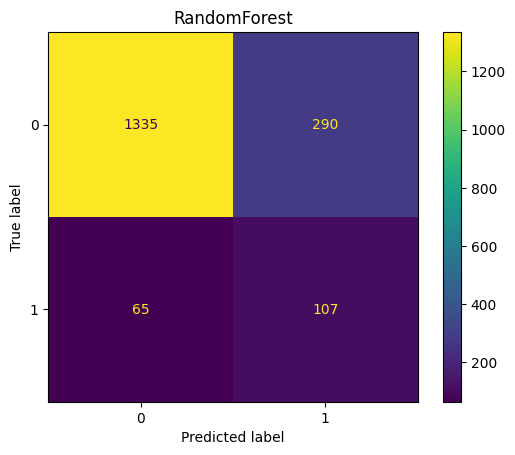

real_positives = 172.0, total = 1797
XGBoost Accuracy: 0.8091263216471898
XGBoost Precision: 0.2755905511811024
XGBoost Recall: 0.6104651162790697
XGBoost Specificity: 0.8301538461538461
XGBoost F1 Score: 0.379746835443038


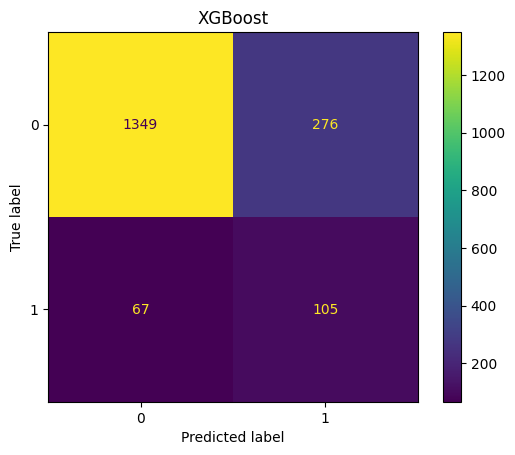

real_positives = 172.0, total = 1797
SupportVectorMachine Accuracy: 0.7996661101836394
SupportVectorMachine Precision: 0.258974358974359
SupportVectorMachine Recall: 0.5872093023255814
SupportVectorMachine Specificity: 0.8221538461538461
SupportVectorMachine F1 Score: 0.3594306049822064


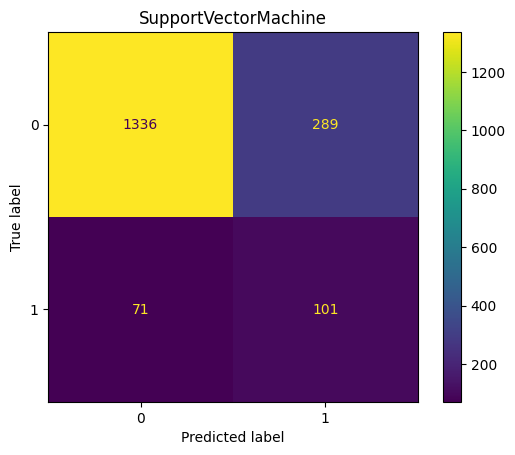

real_positives = 172.0, total = 1797
MLP Accuracy: 0.7941012799109627
MLP Precision: 0.2631578947368421
MLP Recall: 0.6395348837209303
MLP Specificity: 0.8104615384615385
MLP F1 Score: 0.3728813559322034


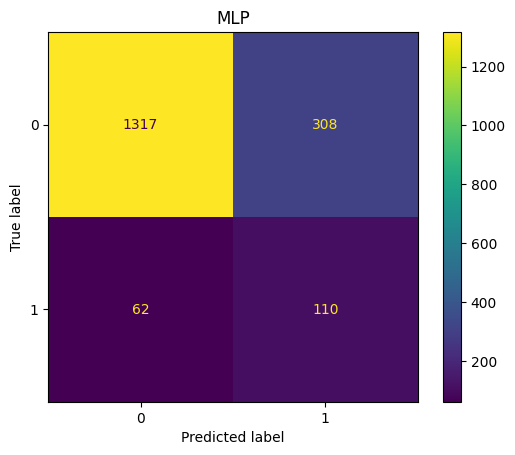

In [50]:
eval(test_data[1], rf.predict(test_data[0]), 'RandomForest')
eval(test_data[1], xgb.predict(test_data[0]), 'XGBoost')
eval(test_data[1], svm.predict(test_data[0]), 'SupportVectorMachine')
eval(test_data[1], mlp.predict(test_data[0]), 'MLP')

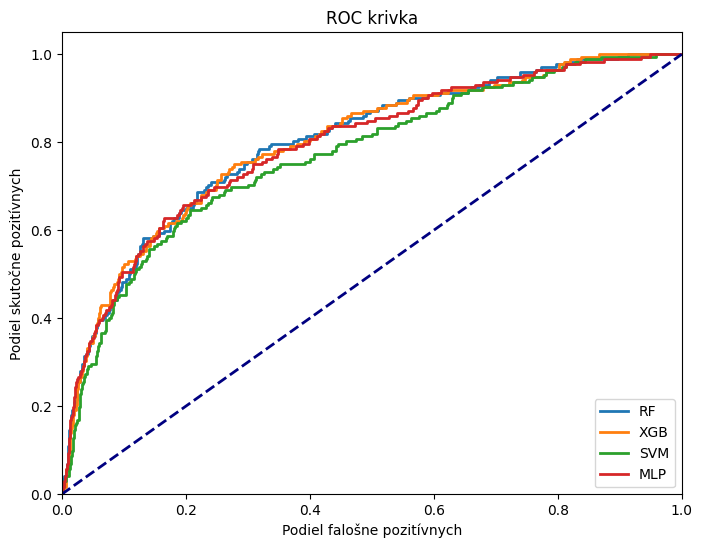

In [59]:
# Compute the ROC curve
rf_roc = roc_curve(test_data[1], rf.predict_proba(test_data[0])[:, 1])
xgb_roc = roc_curve(test_data[1], xgb.predict_proba(test_data[0])[:, 1])
svm_roc = roc_curve(test_data[1], svm.predict_proba(test_data[0])[:, 1])
mlp_roc = roc_curve(test_data[1], mlp.predict_proba(test_data[0])[:, 1])

# fpr, tpr, thresholds = roc_curve(test_data[1], rf.predict_proba(test_data[0]))
# fpr, tpr, thresholds = roc_curve(test_data[1], rf.predict_proba(test_data[0]))


# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(rf_roc[0], rf_roc[1], lw=2, label=f'RF')
plt.plot(xgb_roc[0], xgb_roc[1], lw=2, label=f'XGB')
plt.plot(svm_roc[0], svm_roc[1], lw=2, label=f'SVM')
plt.plot(mlp_roc[0], mlp_roc[1], lw=2, label=f'MLP')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Podiel falošne pozitívnych')
plt.ylabel('Podiel skutočne pozitívnych')
plt.title('ROC krivka')
plt.legend(loc='lower right')
plt.show()

In [81]:
def eval_proba(x, threshold = 0.5):
    return 1 if x >= threshold else 0


testing_raw['proba_rf'] = rf.predict_proba(testing_raw[FINAL_FEATURE_SET])[:, 1]
testing_raw['proba_xgb'] = xgb.predict_proba(testing_raw[FINAL_FEATURE_SET])[:, 1]
testing_raw['proba_svm'] = svm.predict_proba(testing_raw[FINAL_FEATURE_SET])[:, 1]
testing_raw['proba_mlp'] = mlp.predict_proba(testing_raw[FINAL_FEATURE_SET])[:, 1]

testing_raw['pred_rf'] = testing_raw['proba_rf'].apply(lambda x: eval_proba(x, 0.5))
testing_raw['pred_xgb'] = testing_raw['proba_xgb'].apply(lambda x: eval_proba(x, 0.5))
testing_raw['pred_svm'] = testing_raw['proba_svm'].apply(lambda x: eval_proba(x, 0.5))
testing_raw['pred_mlp'] = testing_raw['proba_mlp'].apply(lambda x: eval_proba(x, 0.5))

testing_raw['pred_40_rf'] = testing_raw['proba_rf'].apply(lambda x: eval_proba(x, 0.4))
testing_raw['pred_40_xgb'] = testing_raw['proba_xgb'].apply(lambda x: eval_proba(x, 0.4))
testing_raw['pred_40_svm'] = testing_raw['proba_svm'].apply(lambda x: eval_proba(x, 0.4))
testing_raw['pred_40_mlp'] = testing_raw['proba_mlp'].apply(lambda x: eval_proba(x, 0.4))

c:\Users\matus.rohal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\matus.rohal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
c:\Users\matus.rohal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [88]:
DISTRESS_FLAGS = [
    'RUZ_cancelled_1y_off',
    'RUZ_cancelled_2y_off',
    'RUZ_cancelled_3y_off',
    'RUZ_indirect_criteria_1y_off',
    'RUZ_indirect_criteria_2y_off',
    'RUZ_indirect_criteria_3y_off',
    'combined_issue_criteria_1y_off',
    'combined_issue_criteria_2y_off',
    'combined_issue_criteria_3y_off'
    'RU_event_1y_off',
    'RU_event_2y_off',
    'RU_event_3y_off']

In [105]:
def summary(data, group, real, prediction):
    # totals = data.groupby(group)['financial_statement_id'].nunique().to_frame(name = 'count')
    all_distressed = data.query(f'{real} == 1').groupby(group)['financial_statement_id'].nunique().to_frame(name = 'all_distressed')
    true_positives_rf = data.query(f'{real} == 1 and {prediction}_rf == 1').groupby(group)['financial_statement_id'].nunique().to_frame(name = 'true_positives_rf')
    true_positives_xgb = data.query(f'{real} == 1 and {prediction}_xgb == 1').groupby(group)['financial_statement_id'].nunique().to_frame(name = 'true_positives_xgb')
    true_positives_svm = data.query(f'{real} == 1 and {prediction}_svm == 1').groupby(group)['financial_statement_id'].nunique().to_frame(name = 'true_positives_svm')
    true_positives_mlp = data.query(f'{real} == 1 and {prediction}_mlp == 1').groupby(group)['financial_statement_id'].nunique().to_frame(name = 'true_positives_mlp')

    summary_df = pd.concat(
        [
            all_distressed,
            true_positives_rf,
            true_positives_xgb,
            true_positives_svm,
            true_positives_mlp
        ], axis = 1)
    
    for col in summary_df.columns:
        summary_df[col] = summary_df[col].fillna(0)

    summary_df['tp_ratio_rf'] = (summary_df['true_positives_rf'] / summary_df['all_distressed']).apply(lambda x: round(x, 2))
    summary_df['tp_ratio_xgb'] = (summary_df['true_positives_xgb'] / summary_df['all_distressed']).apply(lambda x: round(x, 2))
    summary_df['tp_ratio_svm'] = (summary_df['true_positives_svm'] / summary_df['all_distressed']).apply(lambda x: round(x, 2))
    summary_df['tp_ratio_mlp'] = (summary_df['true_positives_mlp'] / summary_df['all_distressed']).apply(lambda x: round(x, 2))
    
    display(summary_df)

In [138]:
def summary_by_criteria(data, prediction):
    # totals = data.groupby(group)['financial_statement_id'].nunique().to_frame(name = 'count')

    summary_records = []

    for criteria in ['RUZ_cancelled_3y_off', 'RUZ_indirect_criteria_3y_off', 'combined_issue_criteria_3y_off', 'RU_event_3y_off']:
        row = dict()
        row['Criteria'] = criteria
        row['threshold'] = '50%'
        row['TOTAL'] = data.query(f'{criteria} == 1')['financial_statement_id'].nunique()
        row['RF'] = data.query(f'{criteria} == 1 and pred_rf == 1')['financial_statement_id'].nunique()
        row['XGB'] = data.query(f'{criteria} == 1 and pred_xgb == 1')['financial_statement_id'].nunique()
        row['SVM'] = data.query(f'{criteria} == 1 and pred_svm == 1')['financial_statement_id'].nunique()
        row['MLP'] = data.query(f'{criteria} == 1 and pred_mlp == 1')['financial_statement_id'].nunique()

        row['RF_ratio'] = f"{round(row['RF'] / row['TOTAL'], 2)}%"
        row['XGB_ratio'] = f"{round(row['XGB'] / row['TOTAL'], 2)}%"
        row['SVM_ratio'] = f"{round(row['SVM'] / row['TOTAL'], 2)}%"
        row['MLP_ratio'] = f"{round(row['MLP'] / row['TOTAL'], 2)}%"

        summary_records.append(row)

    
    for criteria in ['combined_issue_criteria_3y_off', 'RUZ_indirect_criteria_3y_off', 'RUZ_cancelled_3y_off', 'RU_event_3y_off']:
        row = dict()
        row['Criteria'] = criteria
        row['threshold'] = '40%'
        row['TOTAL'] = data.query(f'{criteria} == 1')['financial_statement_id'].nunique()
        row['RF'] = data.query(f'{criteria} == 1 and pred_40_rf == 1')['financial_statement_id'].nunique()
        row['XGB'] = data.query(f'{criteria} == 1 and pred_40_xgb == 1')['financial_statement_id'].nunique()
        row['SVM'] = data.query(f'{criteria} == 1 and pred_40_svm == 1')['financial_statement_id'].nunique()
        row['MLP'] = data.query(f'{criteria} == 1 and pred_40_mlp == 1')['financial_statement_id'].nunique()

        row['RF_ratio'] = f"{round(row['RF'] / row['TOTAL'], 2)}%"
        row['XGB_ratio'] = f"{round(row['XGB'] / row['TOTAL'], 2)}%"
        row['SVM_ratio'] = f"{round(row['SVM'] / row['TOTAL'], 2)}%"
        row['MLP_ratio'] = f"{round(row['MLP'] / row['TOTAL'], 2)}%"

        summary_records.append(row)
    

    summary_df = pd.DataFrame(summary_records)
    
    print(summary_df[['Criteria', 'threshold', 'TOTAL', 'RF_ratio',
       'XGB_ratio', 'SVM_ratio', 'MLP_ratio']].to_latex(index=False))
    
    display(summary_df[['Criteria', 'threshold', 'TOTAL', 'RF_ratio',
       'XGB_ratio', 'SVM_ratio', 'MLP_ratio']])

In [146]:
def summary_by_offset(data, prediction):
    # totals = data.groupby(group)['financial_statement_id'].nunique().to_frame(name = 'count')

    summary_records = []

    for criteria in ['combined_issue_criteria_1y_off', 'combined_issue_criteria_2y_off', 'combined_issue_criteria_3y_off']:
        row = dict()
        row['Criteria'] = criteria
        row['threshold'] = '50%'
        row['TOTAL'] = data.query(f'{criteria} == 1')['financial_statement_id'].nunique()
        row['RF'] = data.query(f'{criteria} == 1 and pred_rf == 1')['financial_statement_id'].nunique()
        row['XGB'] = data.query(f'{criteria} == 1 and pred_xgb == 1')['financial_statement_id'].nunique()
        row['SVM'] = data.query(f'{criteria} == 1 and pred_svm == 1')['financial_statement_id'].nunique()
        row['MLP'] = data.query(f'{criteria} == 1 and pred_mlp == 1')['financial_statement_id'].nunique()

        row['RF_ratio'] = f"{round(row['RF'] / row['TOTAL'], 2)}%"
        row['XGB_ratio'] = f"{round(row['XGB'] / row['TOTAL'], 2)}%"
        row['SVM_ratio'] = f"{round(row['SVM'] / row['TOTAL'], 2)}%"
        row['MLP_ratio'] = f"{round(row['MLP'] / row['TOTAL'], 2)}%"

        summary_records.append(row)

    
    for criteria in ['combined_issue_criteria_1y_off', 'combined_issue_criteria_2y_off', 'combined_issue_criteria_3y_off']:
        row = dict()
        row['Criteria'] = criteria
        row['threshold'] = '40%'
        row['TOTAL'] = data.query(f'{criteria} == 1')['financial_statement_id'].nunique()
        row['RF'] = data.query(f'{criteria} == 1 and pred_40_rf == 1')['financial_statement_id'].nunique()
        row['XGB'] = data.query(f'{criteria} == 1 and pred_40_xgb == 1')['financial_statement_id'].nunique()
        row['SVM'] = data.query(f'{criteria} == 1 and pred_40_svm == 1')['financial_statement_id'].nunique()
        row['MLP'] = data.query(f'{criteria} == 1 and pred_40_mlp == 1')['financial_statement_id'].nunique()

        row['RF_ratio'] = f"{round(row['RF'] / row['TOTAL'], 2)}%"
        row['XGB_ratio'] = f"{round(row['XGB'] / row['TOTAL'], 2)}%"
        row['SVM_ratio'] = f"{round(row['SVM'] / row['TOTAL'], 2)}%"
        row['MLP_ratio'] = f"{round(row['MLP'] / row['TOTAL'], 2)}%"

        summary_records.append(row)
    

    summary_df = pd.DataFrame(summary_records)
    
    print(summary_df[['Criteria', 'threshold', 'TOTAL', 'RF_ratio',
       'XGB_ratio', 'SVM_ratio', 'MLP_ratio']].to_latex(index=False))
    
    display(summary_df[['Criteria', 'threshold', 'TOTAL', 'RF',
       'XGB', 'SVM', 'MLP']])

In [147]:
# summary_by_criteria(testing_raw, 'pred')
summary_by_offset(testing_raw, 'pred')

\begin{tabular}{llrllll}
\toprule
                      Criteria & threshold &  TOTAL & RF\_ratio & XGB\_ratio & SVM\_ratio & MLP\_ratio \\
\midrule
combined\_issue\_criteria\_1y\_off &       50\% &     68 &    0.88\% &     0.85\% &     0.75\% &     0.79\% \\
combined\_issue\_criteria\_2y\_off &       50\% &    113 &    0.73\% &     0.72\% &     0.66\% &     0.74\% \\
combined\_issue\_criteria\_3y\_off &       50\% &    172 &    0.62\% &     0.61\% &     0.59\% &     0.64\% \\
combined\_issue\_criteria\_1y\_off &       40\% &     68 &    0.93\% &     0.93\% &     0.84\% &     0.84\% \\
combined\_issue\_criteria\_2y\_off &       40\% &    113 &    0.79\% &     0.81\% &     0.73\% &     0.78\% \\
combined\_issue\_criteria\_3y\_off &       40\% &    172 &    0.72\% &     0.72\% &      0.7\% &     0.72\% \\
\bottomrule
\end{tabular}



,Criteria,threshold,TOTAL,RF,XGB,SVM,MLP
0,combined_issue_criteria_1y_off,50%,68,60,58,51,54
1,combined_issue_criteria_2y_off,50%,113,82,81,75,84
2,combined_issue_criteria_3y_off,50%,172,107,105,101,110
3,combined_issue_criteria_1y_off,40%,68,63,63,57,57
4,combined_issue_criteria_2y_off,40%,113,89,91,83,88
5,combined_issue_criteria_3y_off,40%,172,124,123,120,123


In [148]:
testing_raw.groupby([['pred_rf', 'pred_xgb', 'pred_svm', 'pred_mlp']])

ValueError: Grouper and axis must be same length